### 1.	Write a scraper to fetch messages posted in Edmunds.com discussion forums. The scraper output should be a .csv file with the following columns: date and message (even though you will only use the messages in your analysis). Before you develop the scraper, carefully study one of the forums on Edmunds.com to understand the html as well as the threading structures. 

#### Dependancies

In [12]:
!pip install selenium
# !apt-get -q update
# !apt install -yq chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
# sys.path.insert(0,r'chromedriver')
from selenium import webdriver 
from nltk.stem import WordNetLemmatizer
import nltk
import string
import unicodedata
import scipy.stats as ss
import collections as col
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome(r'chromedriver',options=chrome_options)
wd.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p434')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankitgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankitgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


#### Scraper Test - Getting User Comment

In [ ]:
# user_message = wd.find_elements_by_xpath('//*[@id="Comment_5757969"]/div/div[3]/div/div[1]')[0]
# wd.execute_script('''
#         var element = document.getElementsByClassName("UserQuote blockquote"), index;
#         for (index = element.length - 1; index >= 0; index--) {
#             element[index].parentNode.removeChild(element[index]);
#         }
#     ''')
# print(user_message.text)

from bs4 import BeautifulSoup

soup = BeautifulSoup(wd.page_source, 'html.parser')
soup.find('blockquote')

for s in soup.select('blockquote'):
  s.extract()

### 2. Fetch around 5000 posts about cars from the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

#### Scraper

In [ ]:
last_page = int(wd.find_elements_by_xpath('//*[@id="PagerBefore"]/a[8]')[0].text)
comments = pd.DataFrame(columns = ['Date', 'comments']) 

for i in range(last_page, last_page-101, -1):
  wd.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(i))
  soup = BeautifulSoup(wd.page_source, 'html.parser')
  soup.find('blockquote')

  for s in soup.select('blockquote'):
    s.extract()
    
  ids = wd.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []

  for i in ids:
    comment_ids.append(i.get_attribute('id'))
  \

  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = wd.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract Message for each user on a page
      user_message = wd.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      comment = user_message.text
                                    
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date, comment]

In [ ]:
comments.head(5000).to_csv('/content/drive/MyDrive/Colab Notebooks/Unstructured Data Analytics/Assignment 1/edmunds-data-without-script.csv')

### Task A: Once you fetch the data, test if the data support Zipf’s law. Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Unstructured Data Analytics/Assignment 1/edmunds-data-without-script.csv")

df.drop('Unnamed: 0', axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(ascending=False, inplace=True)
df.head(3)

,comments
Date,
2020-02-25 12:30:00,"Michaell said:\nshow previous quotes\n$12,200 ..."
2020-02-25 12:30:00,wow
2020-02-25 11:58:00,"dino001 said:\nBTW, I looked into incentives o..."


In [ ]:
# convert df into a list
comments_list = [str(i) for i in list(df.comments)]

# remove all \n from the text
comments_string = " ".join(comments_list)
comments_string = comments_string.replace('\n', '')

# tokenization
tokens = word_tokenize(comments_string)
print('Total number of Tokens: ' + str(len(tokens)))

# convert to lower case
tokens = [w.lower() for w in tokens]

print('\n First 10 Tokens')
print(tokens[:10])

Total number of Tokens: 634945

 First 10 Tokens
['michaell', 'said', ':', 'show', 'previous', 'quotes', '$', '12,200', 'lease', 'cash']


In [ ]:
c = col.Counter(tokens)
counts = c.most_common(100)
print (counts[:10])

[('the', 29649), (',', 27332), ('.', 20972), ('a', 14460), ('i', 12563), ('to', 12461), ('and', 12005), ('of', 9113), ('it', 8140), ('is', 8126)]


Text(0, 0.5, 'Frequency')

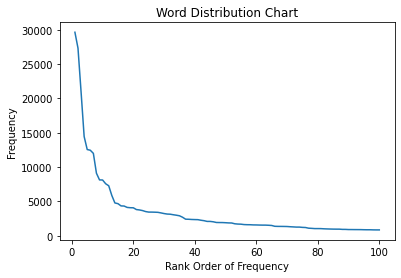

In [ ]:
df_tokens = pd.DataFrame(tokens)
df_tokens_frequency = df_tokens.groupby([0])[0].agg(['count']).sort_values(by='count', ascending=False).head(100)
df_tokens_frequency['count'] = df_tokens_frequency['count'].astype(float)
freq = list(df_tokens_frequency['count'])
rank_order = np.arange(1, len(freq)+1)

plt.plot(rank_order, freq)
plt.title('Word Distribution Chart')
plt.xlabel('Rank Order of Frequency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Log (Frequency)')

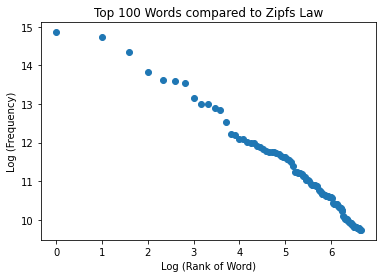

In [ ]:
log_freq = list(np.log2(df_tokens_frequency['count']))
log_rank_order = np.log2(rank_order)

plt.scatter(log_rank_order, log_freq)
plt.title('Top 100 Words compared to Zipfs Law')
plt.xlabel('Log (Rank of Word)')
plt.ylabel('Log (Frequency)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Log (Frequency)')

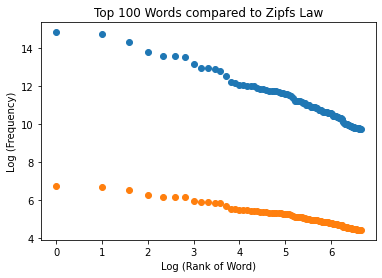

In [ ]:
import statsmodels.api as sm

y = np.array(log_rank_order)
X = np.array([x / (len(log_freq) * freq[len(freq)-1]) for x in log_freq])
res = sm.OLS(y, X).fit()
y_pred = res.predict(X)

plt.scatter(log_rank_order, log_freq)
plt.scatter(log_rank_order, y_pred)
plt.title('Top 100 Words compared to Zipfs Law')
plt.xlabel('Log (Rank of Word)')
plt.ylabel('Log (Frequency)')

### Task B: Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.   

In [ ]:
models_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Unstructured Data Analytics/Assignment 1/car models brands.csv")
models_dict = dict(zip(models_df.Model, models_df.Brand))
list(models_dict.items())[:5]

[('integra', 'acura'),
 ('legend', 'honda'),
 ('vigor', 'acura'),
 ('rlx', 'acura'),
 ('ilx', 'acura')]

In [ ]:
import re

# convert df into a text string
text = [str(i) for i in list(df.comments)]
text = " ".join(text)

model_freq = []
brand_freq = []
models_list = models_dict.keys()
brands_list = np.unique(list(models_dict.values()))

# replacing all models in the text with their brand name
for model in models_list:
  text = re.sub(model, models_dict[model], text)

# finding frequency of each brand name from the text
for brand in brands_list:
  brand_freq.append(len(re.findall(brand, text)))

new = pd.DataFrame(brand_freq, index = brands_list, columns=['Frequency'])
new = new.sort_values(by='Frequency', ascending=False)
new.head(10)

,Frequency
car,6069
toyota,4006
bmw,658
seat,599
honda,491
sedan,359
problem,328
audi,294
dodge,266
nissan,227


In [ ]:
# def remove_accented_chars(text):
#     new_text = []
#     for i in text:
#       new_text.append(unicodedata.normalize('NFKD', i).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
#     return new_text

# # convert df into a list
# text = [str(i) for i in list(df.comments)]

# # remove all \n from the text
# text = " ".join(text)
# text = text.replace('\n', '')

# # tokenization
# tokens = word_tokenize(text)
# print('Initial Tokens: ' + str(len(tokens)))

# # convert to lower case
# tokens = [w.lower() for w in tokens]
# print('Conversion to Lower Case: ' + str(len(tokens)))

# # remove all empty strings
# all_char = string.ascii_lowercase.replace("", " ")[1: -1].split(" ")[1:]
# tokens = [i for i in tokens if i and not i in all_char]
# print('Removing empty strings: ' + str(len(tokens)))

# # remove punctuation from each word
# table = str.maketrans('', '', string.punctuation)
# stripped = [w.translate(table) for w in tokens]
# print('Removing punctuations: ' + str(len(tokens)))

# # filter out stop words
# stop_words = set(stopwords.words('english'))
# tokens = [w for w in tokens if not w in stop_words]
# print('Filtering Stop Words: ' + str(len(tokens)))

# # function to remove accented characters 
# tokens = remove_accented_chars(tokens)
# print('Removing Accented Characters: ' + str(len(tokens)))

# print('\n First 10 Tokens')
# print(tokens[:10])